# Introduction

This is the validation notebook for the PySAL implementation of the local spatial heteroscedasticity (LOSH) statistic. This notebook will begin with a brief review of the LOSH statistic and a manual calculation of the values on a 'toy' dataset. We will then introduce the PySAL implementation of the `LOSH` function. Output from the `LOSH` function will be compared to the results from the manual calculation on the 'toy' dataset. Following the 'toy' dataset will be a comparison of the PySAL `LOSH` function to the external `R` `spdep::LOSH()` function on an external dataset. As of now, calculations of inference are not included in the function.


1. [Review of the LOSH statistic](#Review)
2. [Manual calculations on a 'toy' dataset](#Toy)
3. [Implementation of LOSH function](#LOSH)
4. [Application of LOSH function on the 'toy' dataset](#LOSHToy)
5. [Application of LOSH function on 'real world' datasets](#LOSHRealWorld)

## Review of the LOSH statistic <a name="Review"></a>

The first step in the LOSH Statistic is first calculating the neighborhood means. While the spatial lag does a good job at calculating the sum, we need to do some minor modifications (i.e. row standardization) to get the mean.

In the terms of Ord and Getis 2012, they define the neighborhood mean as:

$$ \bar{x}_i (d) = \frac{\sum_j w_{ij} (d) x_j}{\sum_j w_{ij}(d)} $$

where $\sum_{j} w_{ij}(d)$ is the spatial lag (i.e. the row standardized spatial lag). With a local mean defined, we can then calculate what Ord and Getis call 'local residuals'. These are the difference between neighboring values of interest ($x_{j}$) and the average value of interest ($\bar{x}$), represented as: 

$$ e_j(d) = x_j - \bar{x}_i(d), j \in N(i,d) $$

We can now calculate the final LOSH measure, $H_i(d)$. As explained by Ord and Getis (2012):
    
$$H_i(d) = \frac{\sum w_{ij}(d) |e_j(d)|^a}{\sum w_{ij}(d)}$$
    
>When a = 1, we have an absolute deviations measure, Hi 1, and when a = 2 a variance measure, Hi2. Clearly, other choices are possible, along with various robust forms to avoid outliers. In order to produce a standard measure, we should divide by the mean absolute deviation or variance for the whole data set.

**As explained later on, we will actually focus on the scaled version of the LOSH statistic.**

To get to a chi-square based inference, we need to calculate variance of $H_i$. The (simplified) equation for variance is defined by Ord and Getis as:

$$ Var_{p}(H_i) = \frac{1}{n-1} \left( \frac{1}{h_1 W_{i1}}\right) ^2 (h_2 - h_1^2) \left[nW_{i2} - W_{i1}^2\right] $$

We will now walk through a manual calculation of this statistic on a 'toy' dataset, the [Airbnb listings prices](http://darribas.org/gds_scipy16/content/data/). Data preprocessing steps are adopted from the scipy2019 conference (further details and tutorial [here](https://github.com/pysal/scipy2019-intermediate-gds/blob/master/docs/_build/deterministic/gds1-relations.md)). The value of interest is **median listing price**.

## Manual calculations on a 'toy' dataset <a name="Toy"></a>

In [1]:
# Load some necessary modules
import pandas as pd
import geopandas as gpd
import pysal.lib as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import shapely.geometry as geom
%matplotlib inline

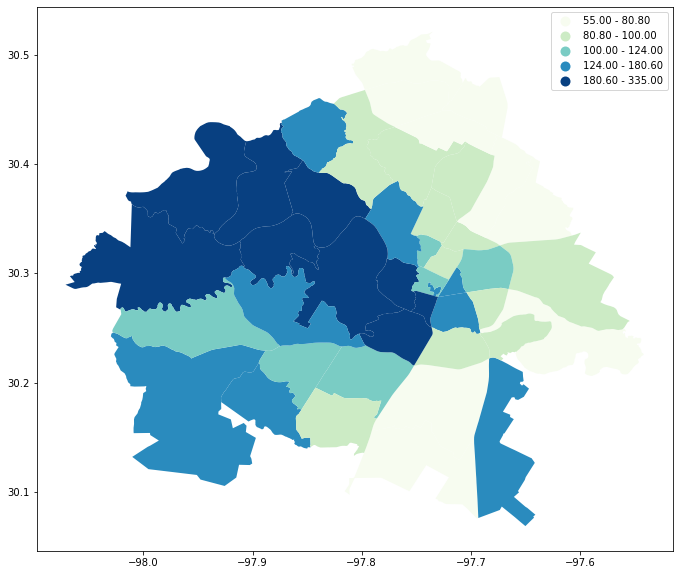

In [60]:
# Load the data
df = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/neighborhoods.gpkg')
listings = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/listings.gpkg')
# Clean the 'price' string
listings['price'] = listings.price.str.replace('$', '').str.replace(',','_').astype(float)
# Get median price
median_price = gpd.sjoin(listings[['price', 'geometry']], df, op='within')\
                  .groupby('index_right').price.median()
# Extract only the values
df['median_pri'] = median_price.values
# Make sure missing values are taken care of
pd.isnull(df['median_pri']).sum()
df = df
df['median_pri'].fillna((df['median_pri'].mean()), inplace=True)
# Plot the data
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)

Now we are ready to build a spatial weights object. There are many types of spatial weights, and we use Queen formation here. Queen weights consider all adjacent polygons as neighbors. The first step is to generate the weights object from our dataset. 

In [4]:
wq = lp.weights.Queen.from_dataframe(df)

Let's inspect wq a bit further. 

In [5]:
wq[0]

{25: 1.0, 3: 1.0, 21: 1.0}

We see that `w` is a moran pysal weights object with indices for each of the $n$ areal units in the dataset. It uses a binary 0/1 system to point to the index of other polygons that are neighbors. In the case of `wq[0]`, those neighbors are 25, 3, and 21. 

An additional important step is called row standardization. Then ensures that if there are multiple neighbors on the same row of a neighborhood matrix, the values are considered part of a weighted average and are adjusted accordingly ($y_i*(1/n)$). For example, if a row has two neighbor values of 50 and 100, each is multiplied by 0.5. **This is effectively the same as taking the spatial mean, rather than the spatial sum**.

In [6]:
wq.transform = 'r'

Let's re-inspect `wq[0]` to see what happened.

In [7]:
wq[0]

{25: 0.3333333333333333, 3: 0.3333333333333333, 21: 0.3333333333333333}

Because `wq[0]` had three neighbors, they are now averaged as $1/n$, or 1/3 (0.333) in this case. This will be different for each `wq[i]`.

However, we have yet to incorporate these weights into any measure or characteristic of interest! Let's use these weights on **median listing price**. Now that we have our spatial weight matrix (`wq`) we can define the core measure of spatial association for our purposes: the spatial lag. The spatial lag is an additive measure of attribute similarity, represented as:

(Eq. 1) $$y_i = \sum_j w_{ij} y_j$$ 

This is generated via the `libpysal` `weights` `lag_spatial` command. 


In [8]:
# Define vector of interest
y = df['median_pri']
# Lag the vector
ylag = lp.weights.lag_spatial(wq, y)
# Print the values
ylag

array([115.        ,  92.5       , 221.6       , 128.33333333,
       112.9       ,  98.33333333, 112.5       , 172.5       ,
       197.6       , 111.        , 101.33333333,  70.        ,
       112.66666667, 147.25      , 125.27777778, 132.3125    ,
        80.        , 119.375     , 137.        , 203.7       ,
        77.33333333, 119.5       , 203.08333333, 114.83333333,
       162.1875    ,  98.4       ,  79.6       ,  91.4375    ,
        88.5       , 165.875     ,  85.        , 156.625     ,
        89.6       , 193.08333333,  94.58333333, 196.33333333,
       233.6       , 101.5625    , 121.35714286, 187.85714286,
       111.7       ,  80.66666667, 229.        , 154.85714286])

How is that first 115 value generated? Well, we can manually recreate it using our knowledge of the spatial weights. Remember, the spatial lag is summing the values of the areal units defined in the weight matrix (either at face value or averaged if row-standardized). Because we already row-standardized the data, we know the calculation will take this averaging into account. 

So let's manually carry out the above equation (1) to match `ylag[0]`:

In [9]:
# Repreint the weight matrix at wq[0]
print(wq[0])
# Get the y values for each identified neighbor
# Remember to multiply based on the row-standardized average value!
print((y[3]*0.3333) + (y[25]*0.3333) + (y[21]*0.3333))

{25: 0.3333333333333333, 3: 0.3333333333333333, 21: 0.3333333333333333}
114.9885


Fantastic! We see that 114.988 is effectively 115 (discrepancy due to rounding). Now that we have some intuition of what's going on, we can turn to the task at hand: the LOSH statistic. 

 **NOTE**: This is a two step procedure. We must first calculate the residuals themselves, and then take the spatial average of them. This is represented as: 

$$ e_j(d) = x_j - \bar{x}_i(d), j \in N(i,d) $$

To get these $e_j(d)$ values, we simply subtract our `ylag` values from `y`:

In [10]:
yresid = y-ylag

A quick validation shows that this is in fact the correct value:


In [11]:
print(yresid[0])
print(y[0])
print(ylag[0])
y[0]-ylag[0]

35.0
150.0
115.0


35.0

Because residuals can sometimes be negative, we have to be careful! In the context of LOSH, this possibility is concerned with absolute or variance deviations. An absolute deviations measure (scenario 1) is when a = 1, or a variance measure (scenario 2) when a = 2. Most users will be interested in scenario 2. We use scenario 2 here:

In [12]:
yresid = abs(yresid)**2
yresid[0]

1225.0

We also want to calculate the spatial lag of the residual values.

In [13]:
lag_resid = lp.weights.lag_spatial(wq, yresid)

Now that we have the residuals, we can now calculate the final **scaled** LOSH measure. This is slightly different and incorporates the **mean of the residuals** in the denominator (see Ord and Getis, 2012):

Average of the absolute (or squared) errors (i.e. residuals):

$$h_1{d} = \sum^n_{i=1} | e_i (d)|^a/n$$

Scaled version of the LOSH statistic:

$$H_i(d) = \frac{\sum w_{ij}(d) |e_j(d)|^a}{ h_{1}(d) \sum w_{ij}(d)}$$


Let's carry out the final $H_i$ calculation by calculating the mean of the residuals and then using that value to divide each of the lagged residuals. Final values for each $i$ areal unit are contained in `Hi`.

In [27]:
# Calculate mean of residuals
yresid_mean = np.mean(yresid)
Hi = lag_resid/yresid_mean
Hi

array([0.02994733, 0.05037736, 0.81581523, 0.58861133, 0.28585921,
       1.54412407, 0.25892339, 2.44041661, 1.01286471, 0.55501043,
       0.05265041, 0.11646834, 0.94735105, 0.80400132, 0.95965242,
       1.62640221, 1.08534645, 1.84522653, 1.21784382, 4.22455343,
       0.30323733, 0.84392127, 3.15858551, 1.02282182, 2.40780699,
       0.86367122, 0.21005193, 0.08462695, 0.48074693, 3.40823975,
       0.0585616 , 0.78132661, 0.02524374, 0.90833485, 0.17737994,
       1.02251044, 4.2363653 , 0.57443862, 0.55754422, 2.46548278,
       0.79040233, 0.17213714, 0.34326507, 0.61876324])

We can also calculate the variance. A step-by-step buide is offered in the [LOSH scratch notebook](https://github.com/jeffcsauer/GSOC2020/blob/master/scratch/LOSH_workbook.ipynb), so we highlight only the python implementation here. To recall, we are implementing a calculation of the following equation:

$$ Var_{p}(H_i) = \frac{1}{n-1} \left( \frac{1}{h_1 W_{i1}}\right) ^2 (h_2 - h_1^2) \left[nW_{i2} - W_{i1}^2\right] $$

The python implementation breaks the equation into four parts with one on each line:

In [15]:
# Define n
n = len(y)
# Calculate VarHi
VarHi = ((len(y)-1)**-1) * \
           ((yresid_mean)**-2) * \
           ((np.sum(yresid**2)/n) - yresid_mean**2) * \
           ((n * (1/np.array(list(wq.cardinalities.values())))) - \
           [np.sum(list(wq[y].values())) for y in range(len(y))])

# Return VarHi
VarHi

array([1.86159399, 1.36214194, 1.06247072, 1.86159399, 1.06247072,
       1.86159399, 1.06247072, 2.86049808, 1.06247072, 0.8626899 ,
       0.8626899 , 1.36214194, 0.8626899 , 1.36214194, 0.52972187,
       0.61296387, 1.36214194, 1.36214194, 0.8626899 , 1.06247072,
       1.86159399, 0.8626899 , 0.8626899 , 0.8626899 , 0.61296387,
       1.06247072, 1.06247072, 0.61296387, 1.06247072, 0.61296387,
       0.8626899 , 0.61296387, 1.06247072, 0.8626899 , 0.8626899 ,
       1.86159399, 1.06247072, 0.61296387, 0.71998931, 0.71998931,
       1.06247072, 0.8626899 , 2.86049808, 0.71998931])

Using these variance values we can obtain chi-square based p-values. This involves calculating the degrees of freedom as:

$$ d.o.f = 2 / Var_p(H_i) $$

Calculating a $Z_i$ statistic as: 

$$ Z_i = (2*H_i)/Var_p(H_i) $$

And, lastly, inputing the $Z_i$ values into a one-sided chi-square equation. 

In [17]:
# Calculate degrees of freedom
dof = 2/VarHi; dof
# Calculating $Z_i$
Zi = (2*Hi)/VarHi; Zi
# One-sided chi-square calculator
from scipy import stats
pval = 1 - stats.chi2.cdf(Zi, dof); pval

array([0.87818074, 0.90444163, 0.43582185, 0.45437587, 0.73797461,
       0.21515135, 0.75846   , 0.12543344, 0.35942128, 0.59968371,
       0.96489066, 0.82675172, 0.39866187, 0.41341508, 0.42487006,
       0.17648759, 0.3217746 , 0.16862153, 0.29874131, 0.01646816,
       0.59818116, 0.4445959 , 0.03521017, 0.36798898, 0.05978169,
       0.41585044, 0.79732592, 0.97518992, 0.60677906, 0.01402701,
       0.96042631, 0.51373556, 0.97003275, 0.41544358, 0.86700486,
       0.31746928, 0.01628388, 0.64614356, 0.62959106, 0.06506969,
       0.44682729, 0.8711434 , 0.48134975, 0.59048787])

## Implementation of LOSH function <a name="LOSH"></a>

The above manual calculations are implemented in the function called `losh`. We copy the most recent draft of the function from the `migration.ipynb` (available on the [jeffcsauer/GSOC2020/scratch](https://github.com/jeffcsauer/GSOC2020/tree/master/scratch) github work journal. 

In [22]:
# https://github.com/pysal/esda/blob/master/esda/lee.py
import numpy
from scipy import sparse
from scipy import stats
from sklearn.base import BaseEstimator
import pysal.lib as lp


class losh(BaseEstimator):
    """Local spatial heteroscedasticity (LOSH)"""

    def __init__(self, connectivity=None, inference=None, standardization=None):
        """
        Initialize a losh estimator

        Arguments
        ---------
        connectivity: scipy.sparse matrix object
                      the connectivity structure describing the relationships
                      between observed units.
        standardization: str
                         defines whether or not the user wants
                         row-standardized weights or abstract weights. options
                         are "row" or "abstract".
        inference: str
                   describes type of inference to be used. options are
                   "chi-square", "permutation", or "simulation".

        Attributes
        ----------
        LOSH_: numpy.ndarray (1,)
               array containing the estimated Local Join Count coefficients,
               where element [0,0] is the number of Local Join Counts, ...
        """
        
        self.connectivity = connectivity
        self.inference = inference
        self.standardization = standardization

    def fit(self, y, a=None, standardization=None):
        """
        Arguments
        ---------
        y       :   numpy.ndarray
                    array containing continuous data
        a       :   int
                    residual multiplier. Default is 2 in order to generate a
                    variance measure. Users may use 1 for absolute deviations.

        Returns
        -------
        the fitted estimator.

        Notes
        -----
        Technical details and derivations can be found in :cite:`OrdGetis2012`.
        """
        y = np.asarray(y).flatten()

        if self.standardization is None:
            print("Warning: No standardization specified, row-standardization assumed.")
            w = self.connectivity
            w.transform = 'r'
        elif self.standardization == "row":
            w = self.connectivity
            w.transform = 'r'
        elif self.standardization == "abstract":
            w = self.connectivity

        self.Hi, self.ylag, self.yresid, self.VarHi = self._statistic(y, w, a)
        
        if self.inference is None:
            return self
        elif self.inference == "chi-square":
            print("Note: chi-square inference selected. This assumes a=2.")
            dof = 2/self.VarHi
            Zi = (2*self.Hi)/self.VarHi
            self.pval = 1 - stats.chi2.cdf(Zi, dof)

        return self

    @staticmethod
    def _statistic(y, w, a):
        # Define what type of variance to use
        if a is None:
            a = 2
        else:
            a = a
        
        transform = w.get_transform()
        
        # Calculate spatial lag (mean when row standardized, sum when not)
        ylag = lp.weights.lag_spatial(w, y)
        # Calculate residuals of y values
        yresid = y-ylag
        # Adjust residuals based on multiplier
        yresid = abs(yresid)**a
        
        # Calculate average of residuals (used as
        # denominator in $H_{i}$ calculation and 
        # in variance alculation)
        yresid_mean = np.mean(yresid)
        # Carry out final $H_{i}$ calculation by dividing
        # spatial average of residuals by mean of residuals
        lag_resid = lp.weights.lag_spatial(w, yresid)
        
        # Define denominator of $H_i$ calculation.
        # If row standardized, use mean of residuals.
        if transform == "R":
            denom = np.mean(yresid)
        # If not row standardized, use sum of lagged y values.
        else:
            denom = np.sum(ylag)
        
        # Calculate Hi
        Hi = lag_resid/denom
        
        # Calculate variance
        n = len(y)
        # Calculate VarHi
        VarHi =    ((len(y)-1)**-1) * \
                   ((yresid_mean)**-2) * \
                   ((np.sum(yresid**2)/n) - yresid_mean**2) * \
                   ((n * (1/np.array(list(w.cardinalities.values())))) - \
                   [np.sum(list(w[y].values())) for y in range(len(y))])       

        return (Hi, ylag, yresid, VarHi)

The LOSH function outputs arrays in the following order: 

- $H_i$: the actual LOSH value
- ylag: the spatial lag of the input y value
- yresid: the spatial lag of the residuals
- $VarH_i$: the variance of the LOSH value
- pval: the associated significance values

## Application of LOSH function on the 'toy' dataset <a name="LOSHToy"></a>

We can now remake the `w` weight object and apply it in the LOSH function.

In [23]:
w = lp.weights.Queen.from_dataframe(df)

Pass `w` and `y` to the LOSH function. 

In [25]:
temp = losh(connectivity=w, standardization="row", inference="chi-square").fit(y)
temp.Hi

Note: chi-square inference selected. This assumes a=2.


array([0.02994733, 0.05037736, 0.81581523, 0.58861133, 0.28585921,
       1.54412407, 0.25892339, 2.44041661, 1.01286471, 0.55501043,
       0.05265041, 0.11646834, 0.94735105, 0.80400132, 0.95965242,
       1.62640221, 1.08534645, 1.84522653, 1.21784382, 4.22455343,
       0.30323733, 0.84392127, 3.15858551, 1.02282182, 2.40780699,
       0.86367122, 0.21005193, 0.08462695, 0.48074693, 3.40823975,
       0.0585616 , 0.78132661, 0.02524374, 0.90833485, 0.17737994,
       1.02251044, 4.2363653 , 0.57443862, 0.55754422, 2.46548278,
       0.79040233, 0.17213714, 0.34326507, 0.61876324])

Compare output of LOSH function to the manually-calculated `Hi`, `VarHi`, and `pval` from above.

In [33]:
temp.Hi == Hi

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [34]:
temp.VarHi == VarHi

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [35]:
temp.pval == pval

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

All match! So our function is outputting the same values from the manual calculations. 

## Application of LOSH function on 'real world' datasets <a name="LOSHRealWorld"></a>

### Comparison to existing `R` `spdep::LOSH()` function

Note that the results from the `R` `spdep::LOSH()` function are executed in `Validation_LOSH_real_world.Rmd`. The 'real world' dataset in question is the [Denver Housing Dataset](https://geodacenter.github.io/data-and-lab//census_2010_excluded-variables/). We specifically want to carry out a LOSH analysis on the NOX variable. 

In [62]:
denver = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/denver/denver.gpkg')
denver.head()

DriverError: '/vsimem/4f1c5debe59e442ab778cfe7af3aeeaa' not recognized as a supported file format.

Isolate the `HU_RENTED` variable and create some spatial weights. 

In [37]:
y_denver = denver['HU_RENTED']

The default weight style is queen and row-standardized in `spdep`. So we will make the same in PySAL.


In [38]:
# Create weights
wq_denver = lp.weights.Queen.from_dataframe(denver)
# Remember that hte function automatically row-standardizes them. An extra standardization does not negatively
# impact the calculations.
wq_denver.transform = 'r'

Now we can calculate the LOSH measures!

In [54]:
temp = losh(connectivity=wq_denver, standardization='row', inference="chi-square").fit(y_denver)

Note: chi-square inference selected. This assumes a=2.


Now let's read in and compare to the values from `spdep::LOSH()`. We round to 3 digits out of convenience.

In [44]:
Hi_spdep = pd.read_csv('C:/Users/jeffe/Dropbox/GSOC2020/validation/data/spdep_denver_losh.csv')
np.round(Hi_spdep['Hi'].values, 3)

array([0.729, 0.606, 1.275, 1.278, 3.664, 0.206, 0.3  , 3.229, 2.473,
       6.219, 4.893, 4.934, 1.949, 0.523, 0.56 , 0.829, 1.053, 0.845,
       0.61 , 0.945, 4.266, 0.963, 1.042, 0.251, 0.17 , 0.427, 2.111,
       1.535, 1.237, 0.274, 0.136, 1.832, 1.525, 0.251, 0.308, 0.47 ,
       0.976, 0.093, 0.529, 0.405, 0.567, 0.265, 0.211, 0.159, 1.476,
       0.538, 0.523, 0.4  , 0.534, 0.042, 2.131, 0.165, 1.19 , 0.051,
       5.3  , 0.606, 1.964, 1.369, 1.014, 0.472, 0.134, 0.116, 0.283,
       0.66 , 0.388, 0.255, 0.217, 0.318, 0.035, 0.418, 1.014, 0.157,
       0.234, 0.212, 0.081])

Final tests.

$H_i$

In [43]:
np.round(temp.Hi, 3) == np.round(Hi_spdep['Hi'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

$ VarH_i $

In [45]:
np.round(temp.VarHi, 3) == np.round(Hi_spdep['Var.Hi'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

$ pvalues $

In [55]:
np.round(temp.pval, 3) == np.round(Hi_spdep['Pr()'].values, 3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

A match (rounded to 3 decimal places, that is). 

# Next steps
 
- Ensure docstrings include all relevant information and formatting
- When constructing demonstration notebooks, ensure that notebooks are standalone (can run both Python and R for validation, use URLs rather than local files, etc...)